# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [1]:
import datetime

from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from exploratory_data_analysis.formatted import utilities
from tqdm.notebook import tqdm
import itertools
from scipy.spatial.distance import jensenshannon
from scipy import stats
from scipy.spatial import distance
import numpy as np

## Get the time series


In [2]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [3]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0709200000, Description: Espárragos frescos o refrigerados


In [4]:
# Generate the time granularities
start_date = heading_data['boarding_date'].min()
end_date = heading_data['boarding_date'].max()

time_granularities = utilities.generate_time_granularities(start_date,end_date)

# import datetime
#
# start_date = datetime.date(2017,1,1)
# end_date = datetime.date(2023,4,29)
#
#
# time_granularities = pd.date_range(start=start_date, end=end_date, freq='D')
# time_granularities = pd.DataFrame(index=time_granularities)
time_granularities

,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
2023-04-18,2023,1,2,4,4,1,2,108,108,18,18,2,16,16,3,3
2023-04-19,2023,1,2,4,4,1,2,109,109,19,19,3,16,16,3,3
2023-04-20,2023,1,2,4,4,1,2,110,110,20,20,4,16,16,3,3


### Daily kilogram's price time series

In [5]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()
# Add the time granularities
usd_kg = pd.concat([usd_kg, time_granularities], axis=1)
usd_kg

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,4.137,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,3.836,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,4.338,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,4.012,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,4.135,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,3.464,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
2023-04-18,4.000,2023,1,2,4,4,1,2,108,108,18,18,2,16,16,3,3
2023-04-19,4.272,2023,1,2,4,4,1,2,109,109,19,19,3,16,16,3,3
2023-04-20,4.272,2023,1,2,4,4,1,2,110,110,20,20,4,16,16,3,3


### Daily total (net) weight exporter time series

In [6]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})
# Add the time granularities
net_weight = pd.concat([net_weight, time_granularities], axis=1)
net_weight

,net_weight,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,275783.770,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,699714.940,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,334919.086,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,508944.540,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,451341.800,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,6720.000,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
2023-04-18,675.000,2023,1,2,4,4,1,2,108,108,18,18,2,16,16,3,3
2023-04-19,22679.000,2023,1,2,4,4,1,2,109,109,19,19,3,16,16,3,3
2023-04-20,0.000,2023,1,2,4,4,1,2,110,110,20,20,4,16,16,3,3


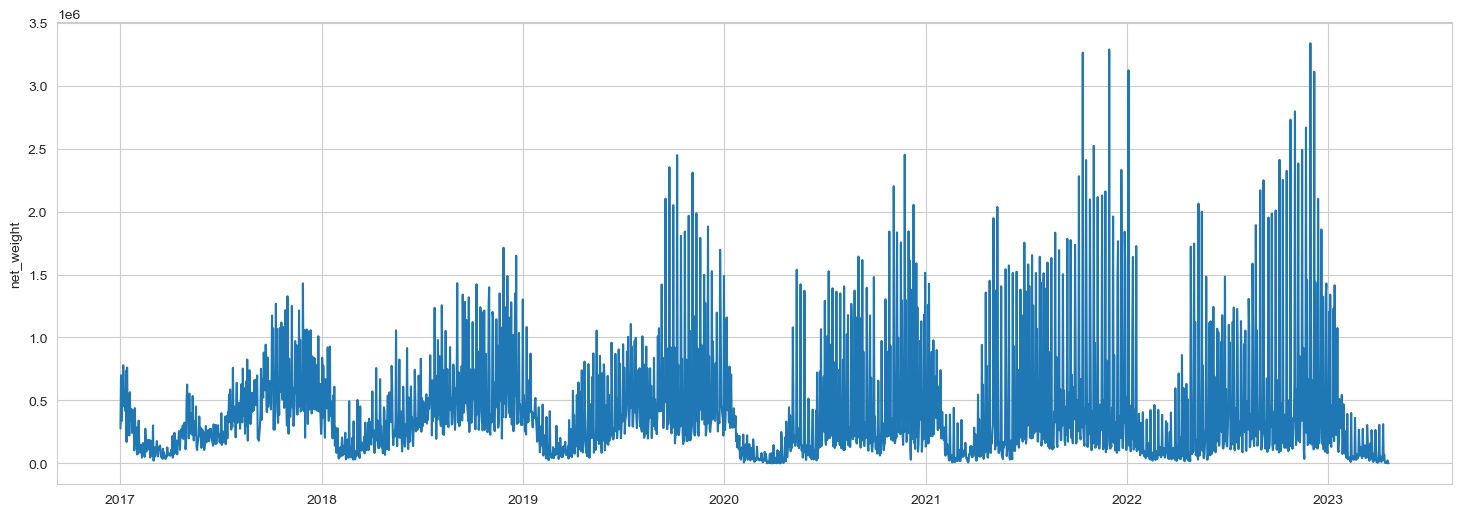

In [7]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x=net_weight.index, y="net_weight", data=net_weight)
plt.show()

In [8]:
# def jensen_shannon(*samples):
#
#     # #Add random perturbations to the observations
#     # samples = [sample + np.abs(np.random.normal(scale=np.std(sample), size=sample.shape))
#     #            for sample in samples]
#     #
#     # #Print the permuted distributions
#     # sns.boxenplot(data=samples,
#     #               k_depth=2,
#     #               showfliers=False,
#     #               palette=['#abaef3'])
#     # plt.show()
#
#     # Get the max and min observation among all the data
#     all_observations = [observation for sample in samples for observation in sample]
#     max_observation = max(all_observations)
#     min_observation = min(all_observations)
#
#     # Define the bins
#     n_bins = 10
#     bins = np.linspace(min_observation, max_observation, n_bins+1)
#
#     # Create the probability vector for each sample
#     probability_vectors = []
#
#     for sample in samples:
#         # take the observations of the respective sample
#         observations = np.array(sample)
#         # count the ocurrences in each bin
#         freq_count, bin_edges = np.histogram(observations, bins=bins)
#         # calculate the probability of each bin
#         probability_vector = freq_count/sum(freq_count)
#         # append to the probability vectors list
#         probability_vectors.append(probability_vector)
#
#     # Get the distances metrics from all pairs
#     pairs = itertools.combinations(probability_vectors, 2)
#
#     distances = []
#     for pair in pairs:
#         jsd = jensenshannon(pair[0], pair[1],base=2)
#         distances.append(jsd)
#
#     # Get the Jensen-Shannon Distances from consecutive samples (time wise speaking)
#     # distances = []
#     # for i in range(len(probability_vectors) - 1):
#     #     jsd = jensenshannon(probability_vectors[i], probability_vectors[i+1], 2)
#     #     distances.append(jsd)
#
#     return max(distances)
#
# def euclidian(*samples):
#
#     # #Add random perturbations to the observations
#     # samples = [sample + np.abs(np.random.normal(scale=np.std(sample), size=sample.shape))
#     #            for sample in samples]
#
#     #Print the permuted distributions
#     # sns.boxplot(data=samples,
#     #               # k_depth=2,
#     #               # showfliers=True,
#     #               palette=['#abaef3'])
#     # plt.show()
#
#     # Create the probability vector for each sample
#     probability_vectors = []
#
#     for sample in samples:
#         # take the observations of the respective sample
#         probability_vector = np.percentile(sample, [25,50,75])
#         # append to the probability vectors list
#         probability_vectors.append(probability_vector)
#
#     # Get the distances metrics from all pairs
#     pairs = itertools.combinations(probability_vectors, 2)
#
#     distances = []
#     for pair in pairs:
#         dis = distance.euclidean(pair[0],pair[1])
#         distances.append(dis)
#
#     return max(distances)
#
# def manhattan(*samples):
#
#     # #Add random perturbations to the observations
#     # samples = [sample + np.abs(np.random.normal(scale=np.std(sample), size=sample.shape))
#     #            for sample in samples]
#
#     #Print the permuted distributions
#     # sns.boxplot(data=samples,
#     #               # k_depth=2,
#     #               # showfliers=True,
#     #               palette=['#abaef3'])
#     # plt.show()
#
#     # Create the probability vector for each sample
#     probability_vectors = []
#
#     for sample in samples:
#         # take the observations of the respective sample
#         probability_vector = np.percentile(sample, [25,50,75])
#         # append to the probability vectors list
#         probability_vectors.append(probability_vector)
#
#     # Get the distances metrics from all pairs
#     pairs = itertools.combinations(probability_vectors, 2)
#
#     distances = []
#     for pair in pairs:
#         dis = distance.cityblock(pair[0],pair[1])
#         distances.append(dis)
#
#     return max(distances)
#
# def time_granularity_analysis(cyclic_granularity,
#                               observations,
#                               data,
#                               distance_metric,
#                               plot,
#                               outliers=True,
#                               n_resamples=1000):
#
#     # Measure seasonality
#     # Get the observations from each subset from the time granularity (sorted by label in ascending order)
#     samples = [data.loc[data[cyclic_granularity] == str(subset), observations].values
#                for subset in sorted(map(int, data[cyclic_granularity].unique()))]
#     # Remove samples with less than 2 observations (caused b leap years, from 2024 this won't be needed)
#     samples = [sample for sample in samples if len(sample) >= 2]
#     # Remove observations above 3 standard deviations from the sample's mean
#     # samples = [sample[(np.abs(sample - np.mean(sample)) < (2*np.std(sample)))] for sample in samples]
#
#     # Permutation test (statistic: max distance metric between pairs of subsets)
#     res = stats.permutation_test(data=samples,
#                                  statistic=distance_metric,
#                                  n_resamples=n_resamples,
#                                  alternative='greater')
#
#     # PLOTS:
#     # Distribution's plot
#     if plot==True:
#         fig, axs = plt.subplots(ncols=2, figsize=(18,6))
#         sns.boxenplot(data=data,
#                         x=cyclic_granularity,
#                         y=observations,
#                         order=[str(i) for i in data[cyclic_granularity].astype(int).sort_values().unique()],
#                         k_depth=2,
#                         showfliers = outliers,
#                         palette=['#abaef3'],
#                         ax=axs[0])
#         axs[0].set_title('{} @ {}'.format(observations, cyclic_granularity))
#
#         # Histogram with the statistics gotten from each permutation
#         axs[1].hist(res.null_distribution, bins=100)
#         axs[1].set_title("Permutation distribution of test statistic")
#         axs[1].set_xlabel("Value of Statistic")
#         axs[1].set_ylabel("Frequency")
#         axs[1].axvline(res.statistic, color='red', linestyle='dashed', linewidth=2)
#         axs[1].text(axs[1].get_xlim()[1]*0.97, axs[1].get_ylim()[1]*0.95, 'Statistic: {:.4f}\np-value: {:.4f}'.format(res.statistic, res.pvalue), ha='right', va='top', fontsize=12)
#         plt.show()
#
#     return {cyclic_granularity: {'statistic':res.statistic, 'pvalue':res.pvalue}}

  0%|          | 0/12 [00:00<?, ?it/s]

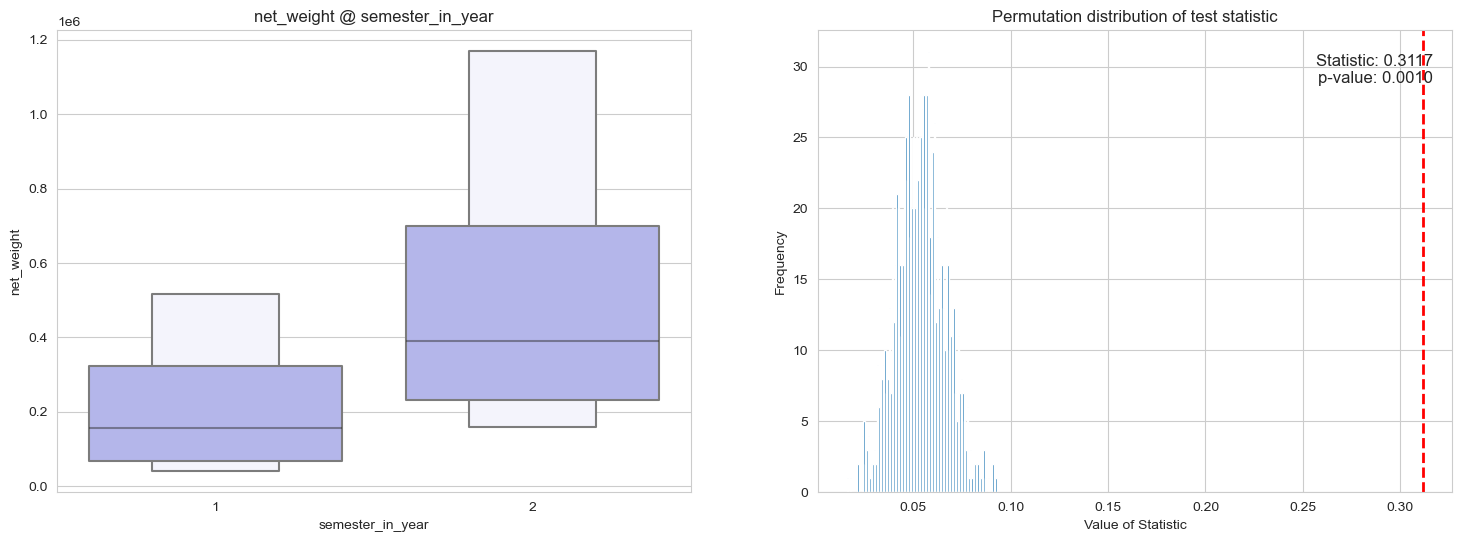

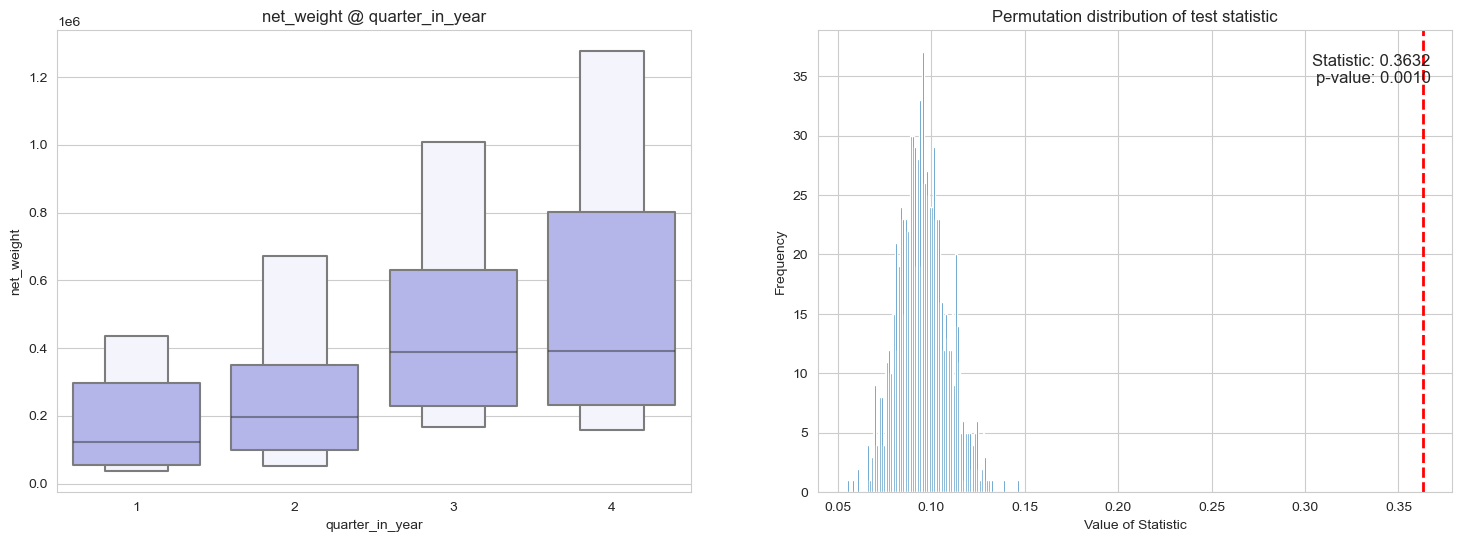

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


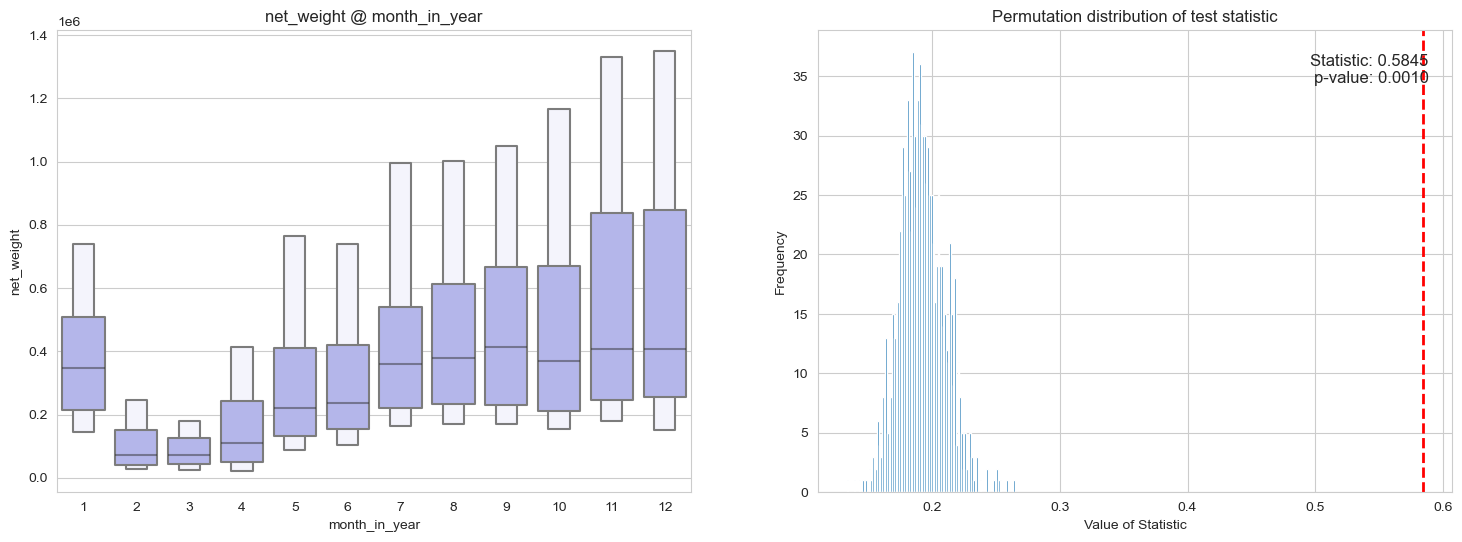

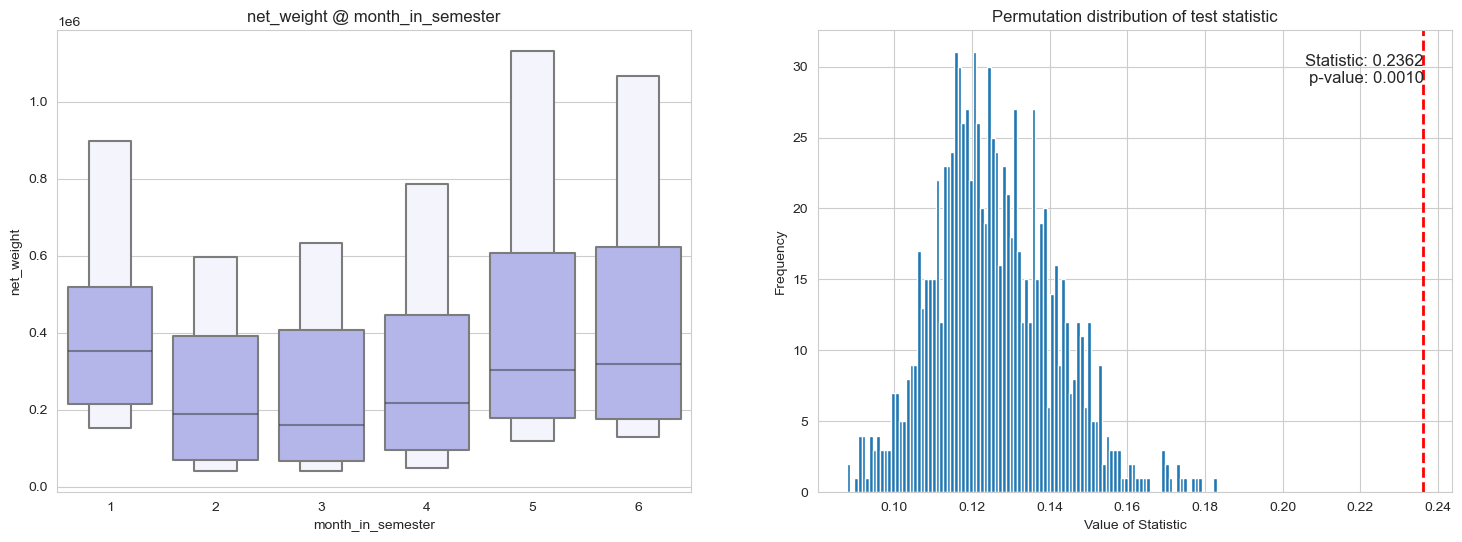

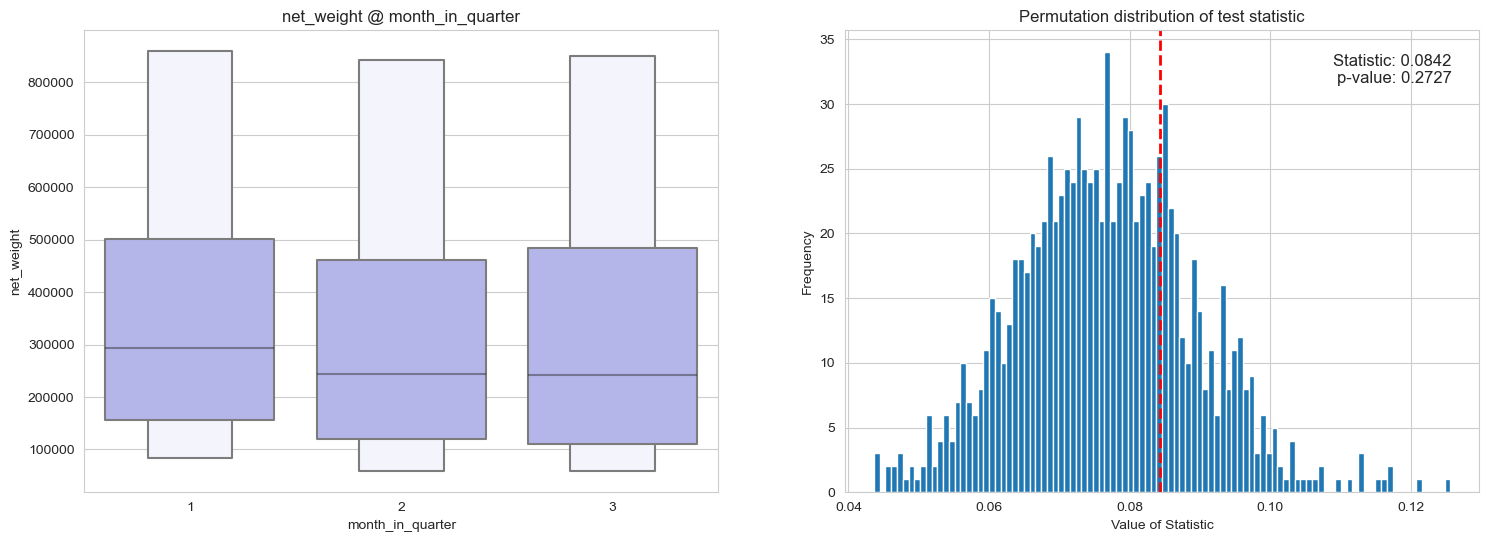

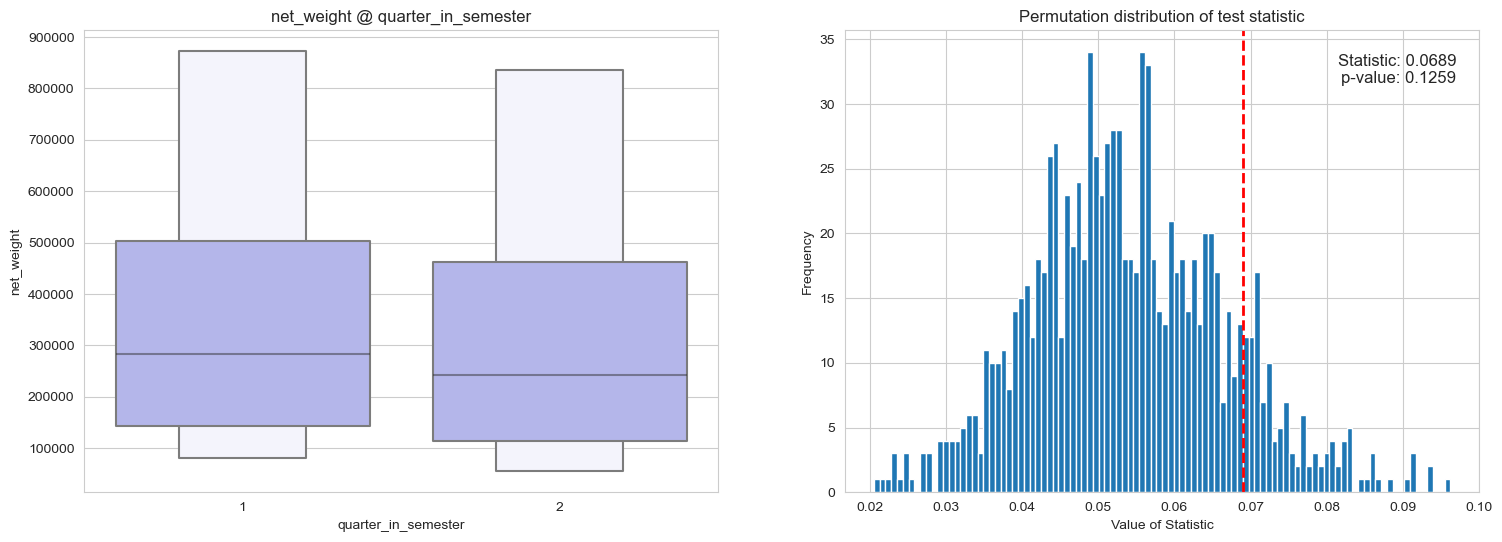

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


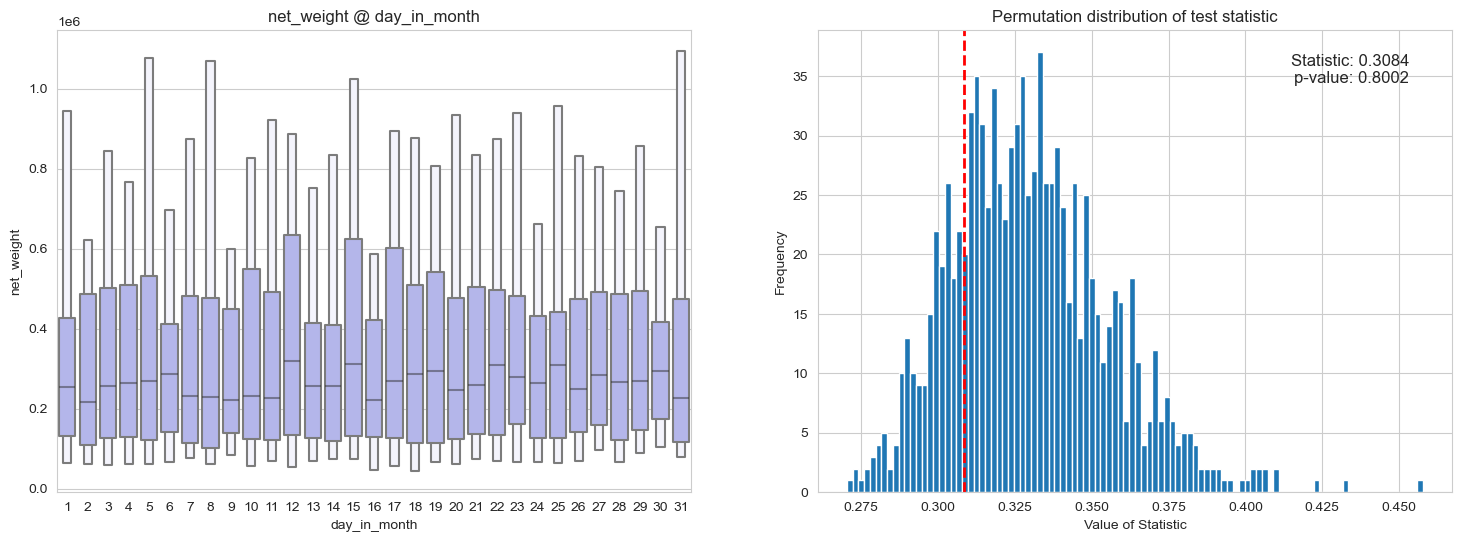

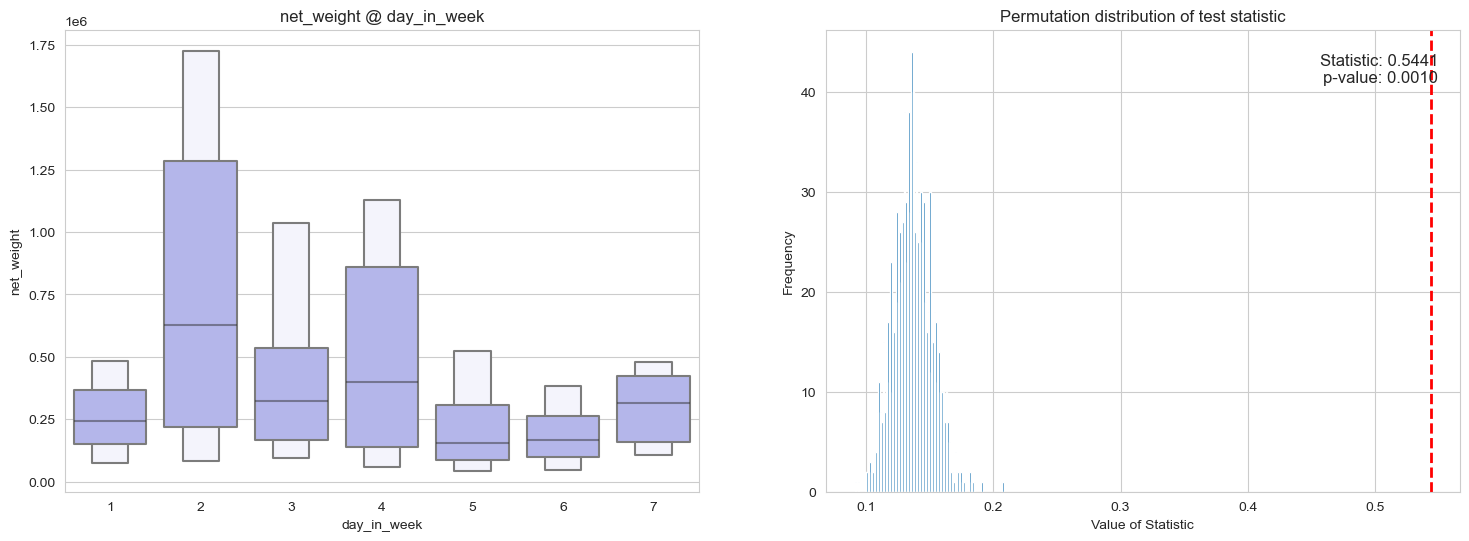

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


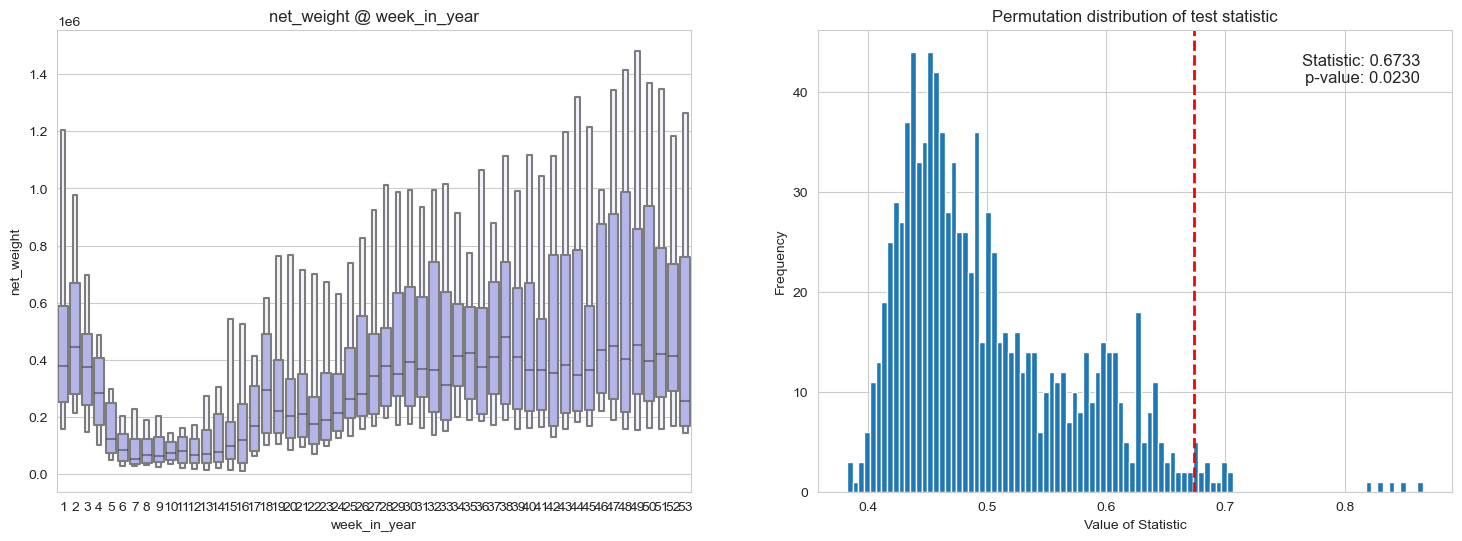

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


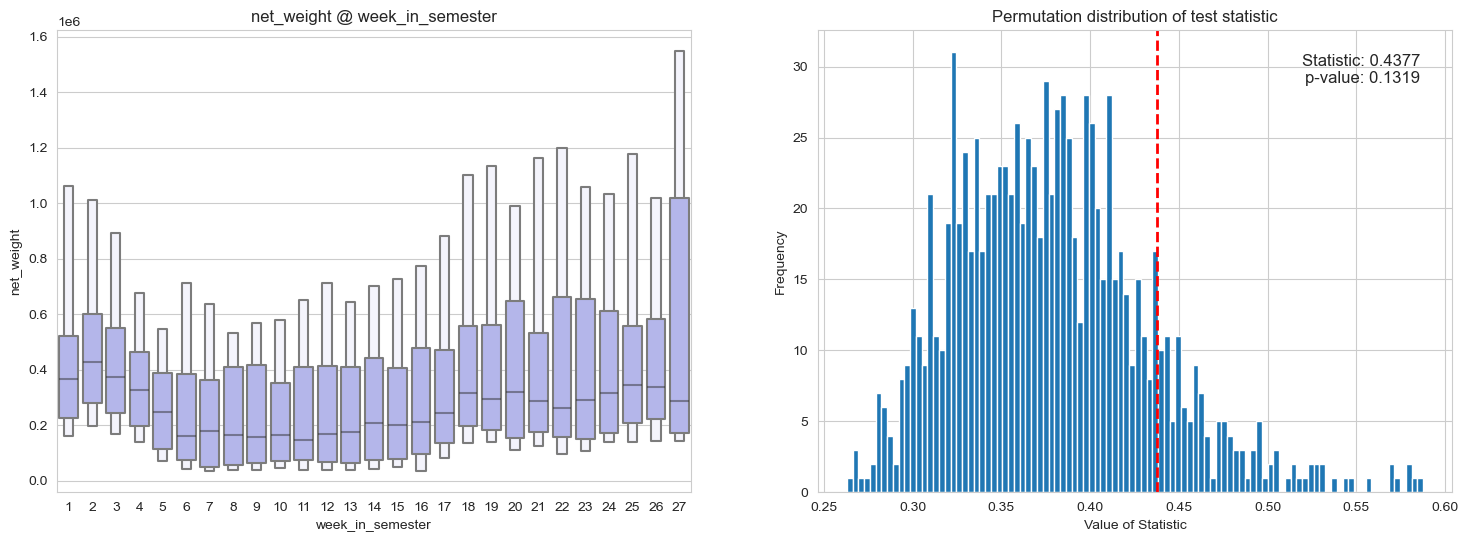

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


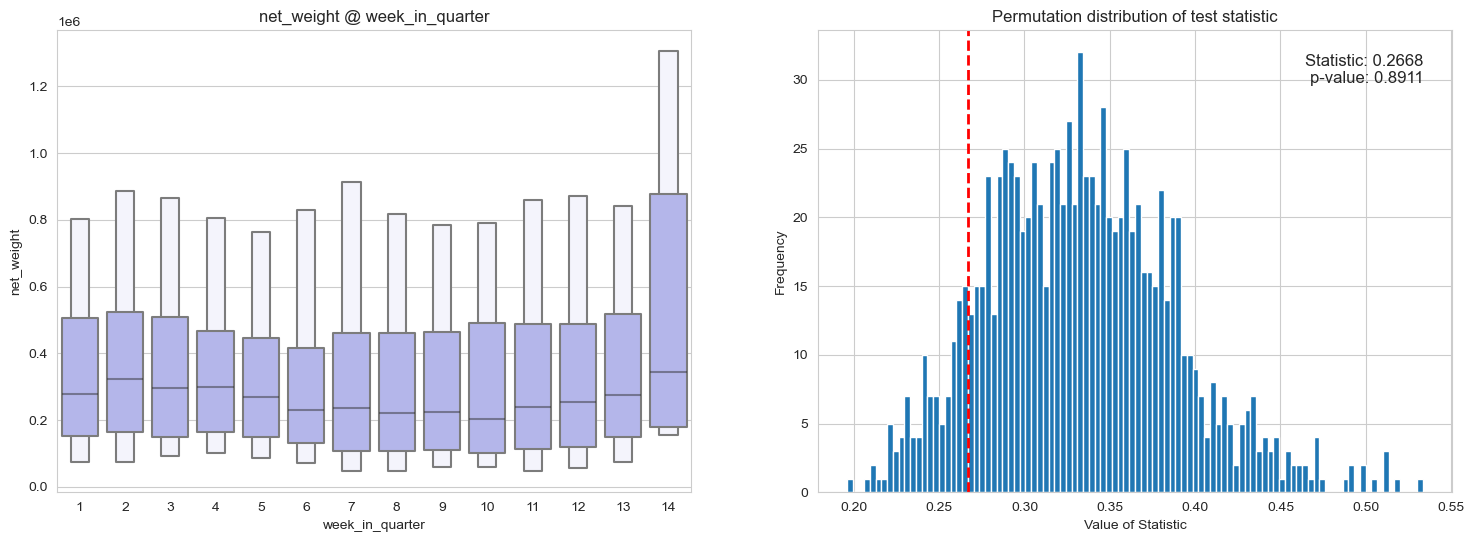

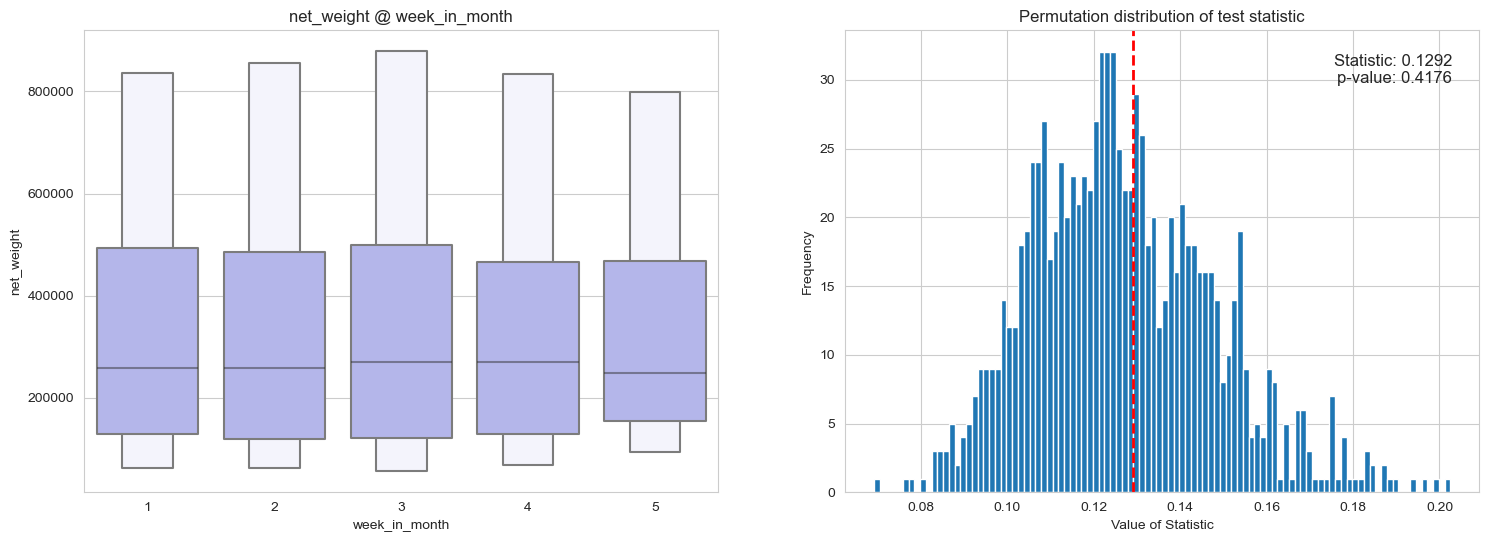

In [10]:
# Set the granularities to analyze
granularities = ['semester_in_year',
                 'quarter_in_year',
                 'month_in_year',
                 'month_in_semester',
                 'month_in_quarter',
                 'quarter_in_semester',
                 #'day_in_year',
                 #'day_in_semester',
                 #'day_in_quarter',
                 'day_in_month',
                 'day_in_week',
                 'week_in_year',
                 'week_in_semester',
                 'week_in_quarter',
                 'week_in_month']

# granularities = ['month_in_semester']

results = {}
for g in tqdm(granularities):
    res = utilities.time_granularity_analysis(cyclic_granularity=g,
                                    observations='net_weight',
                                    data=net_weight,
                                    distance_metric=utilities.jensen_shannon,
                                    plot=True,
                                    outliers=False,
                                    n_resamples=1000)
    results.update(res)

In [11]:
# Assess the significance
significance_threshold = 0.01
analysis = pd.DataFrame.from_dict(results, orient='index').reset_index()
analysis = analysis.rename(columns={'index': 'granularity'})
analysis['significant'] = analysis['pvalue'] < significance_threshold
analysis

,granularity,statistic,pvalue,significant
0,semester_in_year,0.311726,0.000999,True
1,quarter_in_year,0.363245,0.000999,True
2,month_in_year,0.584529,0.000999,True
3,month_in_semester,0.236168,0.000999,True
4,month_in_quarter,0.084240,0.272727,False
5,quarter_in_semester,0.068949,0.125874,False
6,day_in_month,0.308389,0.800200,False
7,day_in_week,0.544090,0.000999,True
8,week_in_year,0.673346,0.022977,False
9,week_in_semester,0.437667,0.131868,False


In [ ]:
# from scipy.spatial.distance import jensenshannon
# import numpy as np
# from scipy import stats
# from sklearn.preprocessing import quantile_transform
# from scipy.stats import norm
#
# def statistic(*samples):
#
#     # Create the probability vector for each sample
#     probability_vectors = []
#     for sample in samples:
#         # take the observations of the respective sample
#         observations = sample
#         # add a random and very small amount of noise in every observation (avoid having all values the same)
#         observations = observations + abs(np.random.normal(loc=0, scale=1e-4, size=len(observations)))
#         # sort the observations in ascending order and reshape
#         observations =  np.sort(observations).reshape(-1, 1)
#         # Data transformation: perform a Normal-Quantile Transformation
#         qnorm = quantile_transform(observations, output_distribution='normal', n_quantiles=len(observations))
#         # Distribution characterization:
#         # get the percentiles
#         percentiles = np.percentile(qnorm, np.linspace(0, 1, num=100)*100)
#         # get the percentiles probabilities
#         cumulative_probability = norm.cdf(percentiles) # This gives the cumulative probability
#         # Get the interpercentile probabilities
#         interpercentile_probabilities = np.insert(np.diff(cumulative_probability), 0, cumulative_probability[0]) # This give the interpercentile probability
#         # append to the probability vectors list
#         probability_vectors.append(interpercentile_probabilities)
#
#     # Get the Jensen-Shannon Distances from consecutive samples (time wise speaking)
#     jensen_shanon_distances = []
#     for i in range(len(probability_vectors) - 1):
#         jsd = jensenshannon(probability_vectors[i], probability_vectors[i+1], 2)
#         jensen_shanon_distances.append(jsd)
#
#     return max(jensen_shanon_distances)